# Import

In [1]:
import pandas as pd
import numpy as np
import pygaze
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
import scipy
import glob

from tqdm import tqdm

In [2]:
pygaze.__version__

'0.7.1'

# Fixation and saccade detection

In [105]:
df_x = pd.read_csv("data/PISSS_ID_003_Approach Two Gaze-Vergence.csv")

In [75]:
# dif = np.abs(df_x["Display"].diff())

In [102]:
# df_x.iloc[3050:3100]

In [103]:
# np.where(dif!=0)[0]

In [104]:
# df_x.loc[3050:3100]

In [89]:
def consecutive(data, stepsize=1):
    return np.split(data, np.where(np.diff(data) != stepsize)[0]+1)

def cleanup(df_data, x_col = "X Pos", y_col = "Y Pos"):
    df_x = df_data.copy()
    dif = np.abs(df_x["Display"].diff())
    for arr in consecutive(np.where(dif!=0)[0]):
        if len(arr) == 1:
            continue
        else:
            df_x.drop(df_x[(df_x.index >= arr[0]) & (df_x.index <=arr[-1]) & (df_x["Display"] == -1)].index, inplace=True)
    
    return df_x

In [90]:
def cal_dist(df_data, x_col = "X Pos", y_col = "Y Pos"):
    df_data[['xnext', 'ynext']] = df_data.loc[1:].reset_index()[[x_col, y_col]]

    def lambda_dist(x, y, xnext, ynext):
        return np.sqrt((xnext - x)**2 + (ynext - y)**2)

    dist = df_data.apply(lambda x: lambda_dist(x[x_col], x[y_col], x['xnext'], x['ynext']), axis=1)[:-1]
    df_data['dist'] = np.insert(dist.values, 0, None)

    return df_data

def detect_fixations(df_data, max_dist = 5, min_dur = 5, x_col = "X Pos", y_col = "Y Pos", time_col = "Start Time (secs)"):
    df_x = df_data.copy()
    df_x = cal_dist(df_x)
    time = df_x[time_col].values
    x = df_x[x_col].values
    y = df_x[y_col].values
    condition = np.array(df_x.iloc[:-1]['dist'].values < max_dist, dtype = int)
    diff = np.diff(condition)
    starts = np.where(diff==1)[0]
    ends = np.where(diff==-1)[0] 
    if len(ends) == 0 or len(starts) == 0: # no fixation
        return []

    if starts[0] > ends[0]: #data starts with fixation
        starts = np.insert(starts,0,0)
    if starts[-1] > ends[-1]: #data ends with fixation
        ends = np.append(ends, len(x) - 1)

    Efix = []
    # compile blink starts and ends
    for i in range(len(starts)):
        # get starting index
        s = starts[i]
        # get ending index
        if i < len(ends):
            e = ends[i]
        elif len(ends) > 0:
            e = ends[-1]
        else:
            e = -1
        # append only if the duration in samples is equal to or greater than
        # the minimal duration
        if e-s >= min_dur:
            meanx = np.mean(x[s:e])
            meany = np.mean(y[s:e])

            # add ending time
            Efix.append([time[s], time[e], time[e]-time[s], meanx, meany])
    
    return Efix

In [106]:
detect_fixations(df_x)

c:\users\khanhhanguyen\appdata\local\continuum\anaconda3\envs\kia\lib\site-packages\ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in less


[[780.017336,
  780.504349,
  0.4870130000000472,
  671.5161166666666,
  441.10518333333334],
 [780.747366,
  780.932375,
  0.1850089999999227,
  860.8527909090909,
  307.13065454545455],
 [781.0724240000001,
  781.236387,
  0.163962999999967,
  918.9497500000001,
  232.44042000000005],
 [781.628424, 782.146434, 0.5180100000000039, 897.321953125, 267.274540625],
 [782.368446, 782.48445, 0.11600400000008904, 713.4131, 431.0251857142857],
 [782.564455,
  782.9364730000001,
  0.3720180000001392,
  673.5157782608695,
  434.2887086956522],
 [783.2485,
  783.572505,
  0.3240049999999428,
  914.6983100000001,
  230.63063500000004],
 [783.6545120000001, 783.734513, 0.08000099999992472, 937.18126, 243.28096],
 [783.814521,
  784.04053,
  0.22600899999997637,
  914.0670499999999,
  212.8429214285714],
 [784.251552, 784.3835799999999, 0.13202799999999115, 901.17155, 295.2902875],
 [784.949589,
  786.60466,
  1.6550710000000208,
  890.5471303921565,
  277.12715784313724],
 [786.686729,
  787.88772

In [107]:
detect_fixations(cleanup(df_x).reset_index())

c:\users\khanhhanguyen\appdata\local\continuum\anaconda3\envs\kia\lib\site-packages\ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in less


[[780.017336,
  780.504349,
  0.4870130000000472,
  671.5161166666666,
  441.10518333333334],
 [780.747366,
  780.932375,
  0.1850089999999227,
  860.8527909090909,
  307.13065454545455],
 [781.0724240000001,
  781.29839,
  0.22596599999997125,
  919.5821000000002,
  230.39993846153845],
 [781.348393, 781.4463969999999, 0.09800399999994625, 920.99298, 215.70942],
 [781.628424, 782.146434, 0.5180100000000039, 897.321953125, 267.274540625],
 [782.368446, 782.48445, 0.11600400000008904, 713.4131, 431.0251857142857],
 [782.564455,
  782.9364730000001,
  0.3720180000001392,
  673.5157782608695,
  434.2887086956522],
 [783.2485,
  783.572505,
  0.3240049999999428,
  914.6983100000001,
  230.63063500000004],
 [783.6545120000001, 783.734513, 0.08000099999992472, 937.18126, 243.28096],
 [783.814521,
  784.04053,
  0.22600899999997637,
  914.0670499999999,
  212.8429214285714],
 [784.251552, 784.3835799999999, 0.13202799999999115, 901.17155, 295.2902875],
 [784.949589,
  786.60466,
  1.655071000

In [96]:
cleanup(df_x).loc[6790:6830]

Display     X Pos     Y Pos  Start Time (secs)  Pupil Diameter
6790        1  913.0900  328.4583         890.179942        5.941243
6791        1  910.7032  325.3792         890.195944        5.991592
6792        1  915.1908  318.9320         890.215976        5.946408
6793        1  912.1208  313.1201         890.233962        5.941515
6794        1  916.7333  300.8195         890.247947        5.905656
6795        1  911.3736  295.4680         890.261956        5.860480
6797        1  911.3687  287.5979         890.293966        6.085834
6798        1  907.5280  282.7047         890.313951        6.100806
6799        1  902.0939  278.2939         890.331951        6.169363
6800        1  899.0780  275.3680         890.345965        6.095917
6801        1  894.8991  279.1625         890.361963        6.048599
6802        1  891.6426  283.7525         890.381970        6.059461
6803        1  888.3459  288.4195         890.393963        6.019779
6804        1  885.3720  292.8236         890.409955        6.022790
6805        1  887.6072  293.3882         890.427976        6.029870
6806        1  888.6787  293.9476         890.441954        6.020336
6807        1  889.4210  294.8387         890.459962        6.026434
6808        1  890.2226  295.6268         890.475997        5.999574
6809        1  890.7260  295.9085         890.491961        5.961563
6810        1  891.1293  296.7648         890.507962        5.927558
6811        1  891.8187  297.6915         890.523962        5.875827
6812        1  892.8389  297.7369         890.539990        5.952522
6813        1  893.6082  298.1324         890.555969        6.018337
6815        1  893.6221  298.4389         890.589962        6.088104
6817        1  893.1882  299.0643         890.623966        6.070998
6819        1  891.8464  300.1875         890.651981        6.058812
6821        1  890.3936  301.0827         890.683972        6.040469
6823        1  888.4733  301.8277         890.715974        6.005352
6825        1  886.4066  302.2827         890.747986        6.000572
6827        1  884.0869  303.1737         890.782973        6.037315
6829        1  881.7714  304.8883         890.814973        6.006807

In [27]:
def lambda_dist(x, y, xnext, ynext):
    return np.sqrt((xnext - x)**2 + (ynext - y)**2)    

In [28]:
df_a = df_x.apply(lambda x: lambda_dist(x['X Pos'], x['Y Pos'], x['xnext'], x['ynext']), axis=1)[:-1]
df_x['dist'] = np.insert(df_a.values, 0, None)

In [29]:
df_x.head(3)

Display     X Pos     Y Pos  Start Time (secs)  Pupil Diameter     xnext  \
0        1  677.0720  446.8252         780.017336        5.774738  676.8422   
1        1  676.8422  445.9810         780.033328        5.724209  676.2347   
2        1  676.2347  445.2086         780.051357        5.689535  674.9990   

      ynext      dist  
0  445.9810       NaN  
1  445.2086  0.874918  
2  444.7492  0.982679

In [30]:
a = np.array(df_x.iloc[:-1]['dist'].values, dtype = int)

c:\users\khanhhanguyen\appdata\local\continuum\anaconda3\envs\kia\lib\site-packages\ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in less
  """Entry point for launching an IPython kernel.


In [24]:
# x = df_x.iloc[:-1]['dist'].values
# mask_1 = x > 5
# mask_2 = x < 10
# a = np.array(np.logical_and(mask_1, mask_2), dtype = int)

In [36]:
x = np.array([1,2,3])
x = np.append(x, 4)
x

array([1, 2, 3, 4])

In [31]:
time = df_x["Start Time (secs)"].values

In [32]:
diff = np.diff(a)

In [33]:
starts = np.where(diff==1)[0] + 1
ends = np.where(diff==-1)[0] + 1

In [14]:
if starts[0] > ends[0]: #data starts with fixation
    starts = np.insert(starts,0,0)
if starts[-1] > ends[-1]: #data ends with fixation
    ends.append(len(diff) - 1)


Efix = []
# compile blink starts and ends
for i in range(len(starts)):
    # get starting index
    s = starts[i]
    # get ending index
    if i < len(ends):
        e = ends[i]
    elif len(ends) > 0:
        e = ends[-1]
    else:
        e = -1
    # append only if the duration in samples is equal to or greater than
    # the minimal duration
    if e-s >= 5:
        # add ending time
        Efix.append([time[s],time[e],time[e]-time[s]])

In [99]:
detect_fixations(cleanup(df_x).reset_index())

c:\users\khanhhanguyen\appdata\local\continuum\anaconda3\envs\kia\lib\site-packages\ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in less


[[780.017336,
  780.504349,
  0.4870130000000472,
  671.5161166666666,
  441.10518333333334],
 [780.747366,
  780.932375,
  0.1850089999999227,
  860.8527909090909,
  307.13065454545455],
 [781.0724240000001,
  781.29839,
  0.22596599999997125,
  919.5821000000002,
  230.39993846153845],
 [781.348393, 781.4463969999999, 0.09800399999994625, 920.99298, 215.70942],
 [781.628424, 782.146434, 0.5180100000000039, 897.321953125, 267.274540625],
 [782.368446, 782.48445, 0.11600400000008904, 713.4131, 431.0251857142857],
 [782.564455,
  782.9364730000001,
  0.3720180000001392,
  673.5157782608695,
  434.2887086956522],
 [783.2485,
  783.572505,
  0.3240049999999428,
  914.6983100000001,
  230.63063500000004],
 [783.6545120000001, 783.734513, 0.08000099999992472, 937.18126, 243.28096],
 [783.814521,
  784.04053,
  0.22600899999997637,
  914.0670499999999,
  212.8429214285714],
 [784.251552, 784.3835799999999, 0.13202799999999115, 901.17155, 295.2902875],
 [784.949589,
  786.60466,
  1.655071000

In [15]:
Efix

[[780.017336, 780.942376, 0.9250399999999672],
 [780.017336, 780.978385, 0.9610490000000027],
 [780.033328, 781.248387, 1.2150589999999966],
 [781.480401, 782.498488, 1.0180869999999231],
 [781.558402, 782.5324519999999, 0.9740499999999201],
 [781.642425, 782.952474, 1.310049000000049],
 [782.384446, 783.2485, 0.8640540000000101],
 [782.514451, 783.588519, 1.0740680000000111],
 [782.582464, 783.6225099999999, 1.0400459999999612],
 [783.670532, 784.673571, 1.003039000000058],
 [783.832523, 786.618668, 2.7861449999999195],
 [784.2715400000001, 787.9017299999999, 3.630189999999857],
 [784.607559, 788.161753, 3.5541939999999386],
 [784.9656, 788.519324, 3.5537239999999883],
 [786.704666, 789.049797, 2.3451310000000376],
 [788.0817969999999, 790.174843, 2.093046000000072],
 [788.291745, 791.015903, 2.7241579999999885],
 [788.632763, 791.22991, 2.5971470000000636],
 [789.2017910000001, 792.4619759999999, 3.260184999999865],
 [790.33685, 792.7379900000001, 2.401140000000055],
 [791.1958950000

In [34]:
starts

array([   1,   46,   58,   66,   78,   81,   83,   86,   90,   95,  100,
        146,  154,  158,  196,  200,  221,  223,  225,  235,  262,  283,
        305,  412,  497,  510,  531,  566,  636,  689,  699,  776,  788,
        974,  991,  996, 1028, 1062, 1073, 1098, 1132, 1187, 1223, 1236,
       1312, 1326, 1335, 1466, 1618, 1643, 1645, 1647, 1704, 1706, 1708,
       1717, 1720, 1722, 1725, 1728, 1773, 1776, 1782, 1801, 1808, 1825,
       1846, 1860, 1970, 1975, 2070, 2142, 2441, 2453, 2547, 2575, 2642,
       2682, 2689, 2765, 2821, 2847, 2902, 2943, 2953, 2965, 2992, 2995,
       3073, 3102, 3104, 3134, 3149, 3153, 3160, 3240, 3307, 3317, 3357,
       3456, 3468, 3471, 3474, 3477, 3554, 3698, 3705, 3723, 3763, 3773,
       3782, 3788, 3825, 3842, 3856, 3872, 3874, 3887, 3891, 3893, 3897,
       3899, 3905, 3907, 3909, 3911, 3913, 3917, 3922, 3937, 3989, 3999,
       4024, 4063, 4166, 4212, 4278, 4281, 4283, 4290, 4386, 4394, 4558,
       4565, 4615, 4625, 4667, 4709, 4777, 4807, 48

In [35]:
ends

array([  31,   57,   59,   76,   80,   82,   84,   89,   94,   97,  132,
        153,  155,  181,  199,  220,  222,  224,  230,  249,  270,  287,
        407,  486,  502,  524,  557,  626,  678,  691,  767,  784,  963,
        990,  992, 1022, 1051, 1069, 1081, 1122, 1177, 1215, 1229, 1308,
       1317, 1332, 1461, 1616, 1642, 1644, 1646, 1703, 1705, 1707, 1716,
       1719, 1721, 1723, 1726, 1772, 1774, 1780, 1798, 1806, 1811, 1842,
       1852, 1958, 1971, 2059, 2127, 2436, 2450, 2537, 2571, 2625, 2681,
       2683, 2754, 2805, 2836, 2890, 2934, 2949, 2955, 2978, 2993, 2998,
       3074, 3103, 3108, 3138, 3152, 3154, 3230, 3306, 3308, 3346, 3428,
       3457, 3470, 3473, 3475, 3478, 3691, 3703, 3713, 3762, 3764, 3781,
       3783, 3815, 3827, 3853, 3869, 3873, 3886, 3890, 3892, 3896, 3898,
       3904, 3906, 3908, 3910, 3912, 3916, 3918, 3929, 3975, 3995, 4020,
       4047, 4155, 4199, 4273, 4280, 4282, 4288, 4385, 4391, 4551, 4563,
       4612, 4622, 4661, 4698, 4767, 4796, 4883, 49

In [140]:
ends

array([  11,   51,   54,   99,  223,  235,  245,  249,  260,  263,  279,
        299,  419,  428,  438,  474,  476,  478,  480,  537,  541,  555,
        559,  640,  644,  683,  694,  722,  735,  763,  913,  960,  964,
        987, 1069, 1078, 1106, 1144, 1149, 1178, 1185, 1193, 1203, 1239,
       1271, 1280, 1330, 1352, 1373, 1395, 1415, 1600, 1603, 1609, 1760,
       1767, 1779, 1799, 1810, 1929, 1937, 1951, 1989, 1998, 2003, 2101],
      dtype=int64)

In [133]:
starts

array([  47,   53,  210,  234,  242,  258,  298,  427,  475,  477,  479,
        536,  554,  557,  639,  669,  693,  721,  907,  959,  969,  975,
       1077, 1140, 1177, 1192, 1237, 1279, 1329, 1381, 1454, 1589, 1608,
       1758, 1766, 1789, 1809, 1888, 1935, 1977, 1997, 2011, 2089, 2108,
       2150], dtype=int64)

In [134]:
ends

array([  30,   51,   99,  228,  235,  251,  279,  419,  474,  476,  478,
        523,  541,  555,  559,  653,  683,  699,  818,  952,  967,  973,
       1069, 1128, 1162, 1185, 1220, 1271, 1315, 1373, 1440, 1574, 1603,
       1727, 1760, 1780, 1799, 1810, 1929, 1962, 1989, 2003, 2024, 2101,
       2136], dtype=int64)

In [ ]:
df_not_null = df_data[df_data["Display"] == 1]

In [ ]:
class Point:
    """
    class to define a Point
    """
    def __init__(self,x,y):
        self.x = x
        self.y = y

In [ ]:
def calculate_gaze_distance(first_point, destination_point):
    """
    calculate gaze distance between 2 points

    Arguments:
        first_point (Point): first point
        destination_point (Point): second point

    Return:
        (float): distance between 2 points
    """
    return np.sqrt((first_point.x - destination_point.x)**2 + (first_point.y - destination_point.y)**2)

def distance_to_gaze_angle(distance_to_view, gaze_distance):
    """
    convert gaze distance to gaze angle
    assume that distances from pilot's eyes to first point and to destionation point are equal

    Arguments:
        distance_to_view (float): distance from pilot's eyes to the control
        gaze_distance (float): gaze distance

    Return:
        (float): angle of the gaze between 2 points

    """
    return np.arccos(1 - (1/2)*((gaze_distance/distance_to_view)**2))

In [ ]:
def calculate_all_distance(list_points):
    """
    Calculate distance between all points consequently

    Arguments:
        list_points (Point): all points
    
    Return:
        all_distance (list(float)): list of distance between Point(n) and Point(n+1)
    
    """
    all_distance = [0]
    for i in range(len(list_points) - 1):
        all_distance.append(calculate_gaze_distance(list_points[i],list_points[i+1]))
    return all_distance

In [ ]:
list_points = []
for i in range(len(df_not_null)):
    x = df_not_null.iloc[i]
    pt = Point(int(float(x["X Pos"])), int(float(x["Y Pos"])))
    list_points.append(pt)


In [ ]:
def fixation_saccade_classification(list_points, distance_threshold, angle_threshold = 5, time_threshold = 140):
    """
    classify fixation and saccade based on the angle of the eye's gaze,
    if a gaze exceeds 5 degree, it will be considered as a saccade

    Arguments:
        list_points (list(Point)): all points
        distance_threshold (float): if a gaze's distance exceeds this threshold, it will be considered as a saccade (to be removed, use angle threshold instead)
        angle_threshold (float): default by 5 degree
        time_threshold (float): in ms, to determine long, short fixation (to do)
    
    Return:
        list_fixation_saccade (list(int)): denote the moment is a fixation (0) or a saccade (1)
    """
    list_distance = calculate_all_distance(list_points)
    list_fixation_saccade = [1 if v > distance_threshold else 0 for v in list_distance]
    list_fixation_saccade = list_fixation_saccade
    return list_fixation_saccade 

In [ ]:
list_fixation_saccade = fixation_saccade_classification(list_points, 13)

In [ ]:
# df_not_null["distance"] = list_distance
df_not_null["fixation/saccade"] = list_fixation_saccade

In [ ]:
x_coord = df_not_null["X Pos"]
y_coord = df_not_null["Y Pos"]

diameter = df_not_null["Pupil Diameter"]
img = plt.imread("flight.jpg")
h,w,c = img.shape

cols=[]

for i in range(len(list_fixation_saccade)):
    if list_fixation_saccade[i] == 0:
        cols.append("red")
    else:
        cols.append("blue")

    
fig=plt.figure(figsize=(15,8))
ax=fig.add_axes([0,0,1,1])
# ax.scatter(x_coord[0], y_coord[0], "-o")
ax.imshow(img, extent=[0, 1600, 0, 900])

ax.plot()
ax.scatter(x=x_coord,y=y_coord,c=cols)


ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_title('gaze')

plt.show()

In [ ]:
df_data[df_data["X Pos"]==0.0]

# Blink, Fixation, Saccade detection

In [94]:
import detectors
import gazeplotter

In [95]:
participant_ID = "004"

In [96]:
df_data = pd.read_csv("data/PISSS_ID_{}_Approach Two Gaze-Vergence.csv".format(participant_ID))

In [97]:
df_data.fillna(0.0, inplace=True)

In [98]:
x = np.array(df_data['X Pos'].tolist())
y = np.array(df_data['Y Pos'].tolist())
time = np.array(df_data['Start Time (secs)'].tolist())*1000

In [99]:
Sblk, Eblk = detectors.blink_detection(x,y,time,minlen=6)

In [100]:
Sfix, Efix = detectors.fixation_detection(x,y,time,maxdist=10,mindur=50)

In [101]:
Ssac, Esac = detectors.saccade_detection(x,y,time,minlen=5,maxvel=40,maxacc=340)

In [79]:
len(Efix)

183

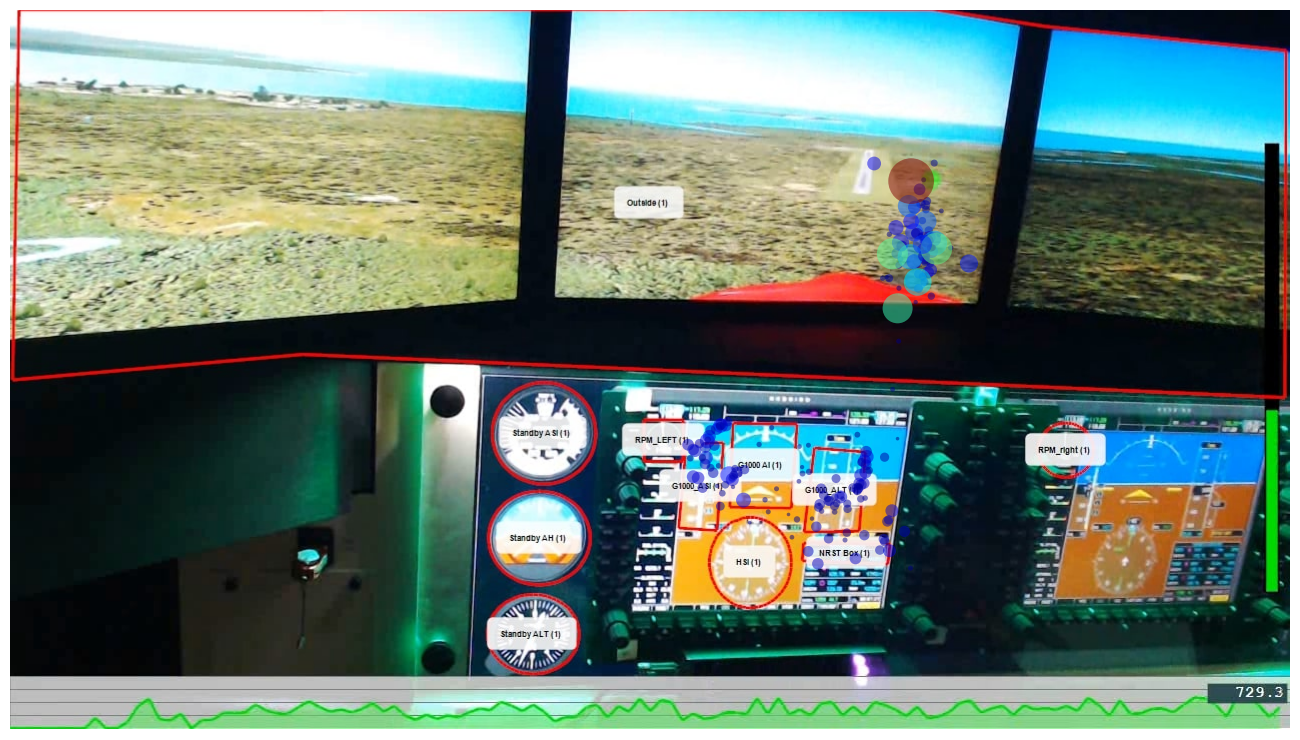

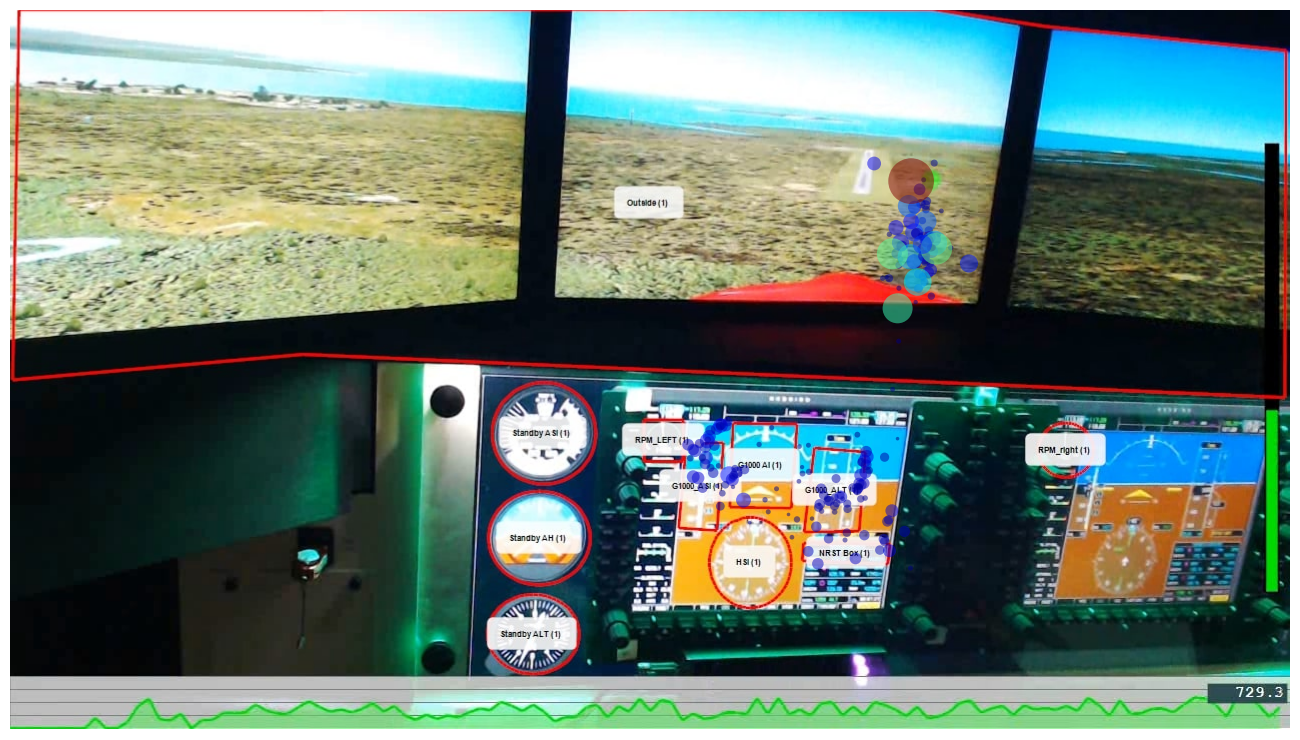

In [80]:
gazeplotter.draw_fixations(Efix, dispsize=(1280,720), imagefile="flight.jpg")

# GTE, SGE

In [102]:
from sklearn.cluster import DBSCAN

In [103]:
X = np.array(Efix).T[3:]
# X = np.array([x,y])

In [104]:
X[0] = X[0] - 20
X[1] = X[1] - 20

X = X.T

In [105]:
def dist_metric(x,y):
    return ((x[0]-y[0])**2 + (x[1] - y[1])**2)**0.5

In [152]:
clustering = DBSCAN(eps=20, min_samples=3, metric = dist_metric).fit(X)

In [112]:
color = clustering.labels_
len(set(color))

6

In [151]:
def get_center(clustering, data):
    center = []
    for i in range(len(set(clustering.labels_)) - 1):
        xi = data[np.where(clustering.labels_ == i)]
        cx = sum(xi.T[0])/len(xi)
        cy = sum(xi.T[1])/len(xi)
        center.append((cx,cy))
    return center

# cluster_center = get_center(clustering,X)

In [142]:
cluster_center = get_center(clustering,X)
cluster_center =[[v[0] for v in cluster_center], [v[1] for v in cluster_center]]

cluster_center

[[888.4575984374995,
  819.4813578947367,
  686.7616243902439,
  773.1518,
  739.9248000000001],
 [214.71169218749998,
  470.39865263157867,
  430.644931707317,
  443.461225,
  470.142]]

Text(0.5, 1.0, 'center')

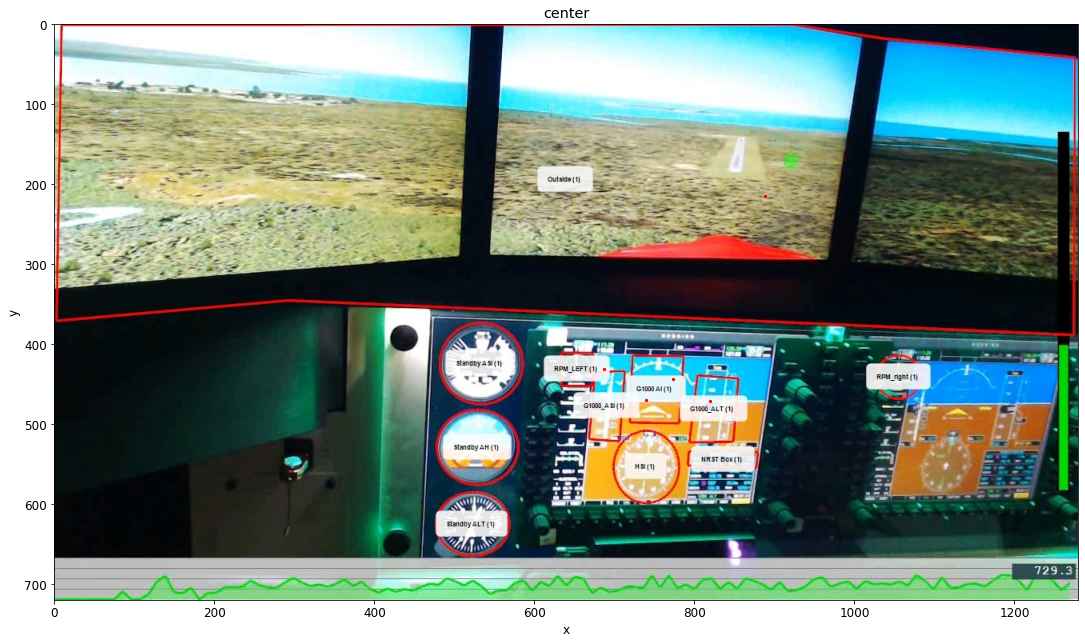

In [115]:
img = plt.imread("flight.jpg")
h,w,c = img.shape
fig=plt.figure(figsize=(15,8))
ax=fig.add_axes([0,0,1,1])
# ax.imshow(img, extent=[0, 1600, 0, 900])
ax.imshow(img)
ax.scatter(cluster_center[0], cluster_center[1], s=5, c = "red")

ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_title('center')

# plt.show()

Text(0.5, 1.0, 'gaze')

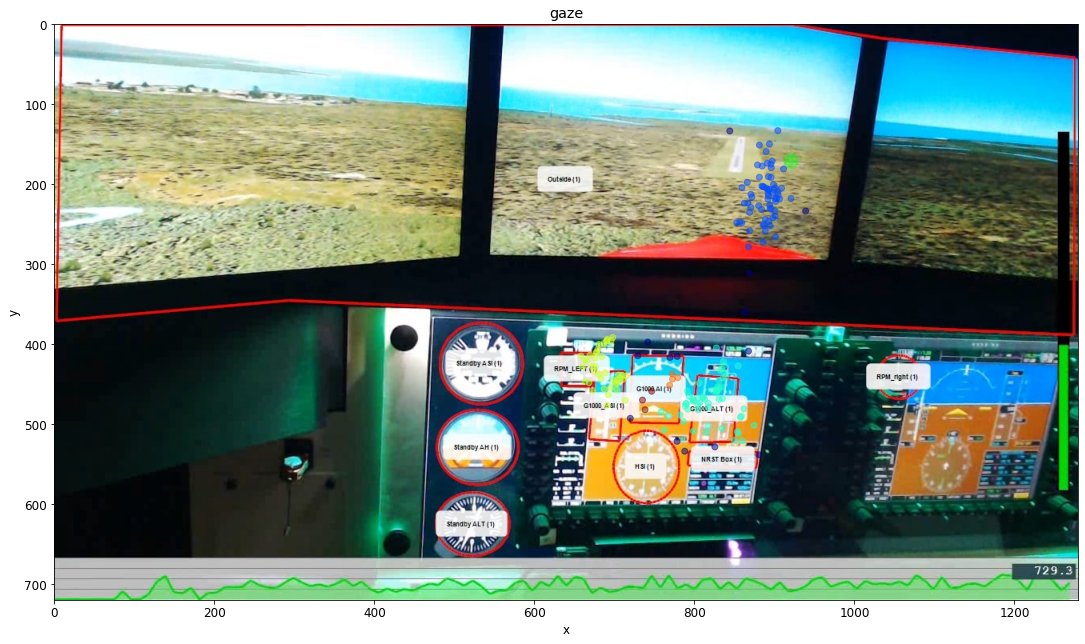

In [111]:
img = plt.imread("flight.jpg")
h,w,c = img.shape
fig=plt.figure(figsize=(15,8))
ax=fig.add_axes([0,0,1,1])
# ax.imshow(img, extent=[0, 1600, 0, 900])
ax.imshow(img)

ax.scatter(X.T[0],X.T[1], c=color, cmap="jet", alpha = 0.5)

ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_title('gaze')

# plt.show()

In [91]:
# gazeplotter.draw_heatmap(Efix, dispsize=(1023,682), imagefile="flight.jpg")

In [119]:
window_length = -1 #10sx60Hz

In [120]:
df_data_window = df_data[:window_length]

In [121]:
wX = np.array(df_data_window['X Pos'].tolist())
wY = np.array(df_data_window['Y Pos'].tolist())
wtime = np.array(df_data_window['Start Time (secs)'].tolist())*1000

In [122]:
wSfix, wEfix = detectors.fixation_detection(wX,wY,wtime,maxdist=20,mindur=50)

In [123]:
len(wEfix)

141

In [124]:
def transition_matrix(transitions):
    n = 1+ max(transitions) #number of states

    M = [[0]*n for _ in range(n)]

    for (i,j) in zip(transitions,transitions[1:]):
        M[i][j] += 1

    #now convert to probabilities:
    for row in M:
        s = sum(row)
        if s > 0:
            row[:] = [f/s for f in row]
    return M


In [125]:
def distance(x,y):
    return ((x[0]-y[0])**2 + (x[1]-y[1])**2)**0.5

def dbscan_predict(cluster_center, X_new, min_dist = 50, metric=distance):
    # Result is noise by default
    y_new = np.ones(shape=len(X_new), dtype=int)*-1 

    # Iterate all input samples for a label
    for j, x_new in enumerate(X_new):
        # Find a core sample closer than EPS
        for i, x_core in enumerate(cluster_center): 
            if metric(x_new, x_core) < min_dist:
                # Assign label of x_core to x_new
                y_new[j] = i
                break

    return y_new

In [154]:
cluster_center

[[888.4575984374995,
  819.4813578947367,
  686.7616243902439,
  773.1518,
  739.9248000000001],
 [214.71169218749998,
  470.39865263157867,
  430.644931707317,
  443.461225,
  470.142]]

In [159]:
pred = dbscan_predict(cluster_center, np.array(wEfix).T[3:].T)

In [160]:
pred

array([-1,  1,  2,  0, -1,  0,  2, -1,  2,  0, -1,  0,  1, -1,  3,  2, -1,
        1,  0,  1, -1, -1, -1,  0,  1,  0, -1,  0,  1,  0, -1,  0,  1,  1,
       -1,  3, -1,  0, -1, -1, -1, -1,  2, -1, -1, -1, -1,  0,  2, -1,  4,
       -1,  1,  2,  2, -1,  3, -1,  4,  2, -1,  3,  2,  3, -1,  2, -1,  1,
       -1,  4,  3,  0,  1,  0,  0,  3,  1, -1,  4,  2, -1,  1,  2, -1,  3,
       -1, -1, -1, -1, -1,  2, -1,  2,  0,  1, -1, -1,  3, -1, -1, -1, -1,
       -1,  2, -1, -1, -1,  2, -1,  3, -1, -1, -1, -1,  3, -1,  2, -1, -1,
       -1,  1, -1,  1, -1,  2, -1, -1, -1,  3, -1,  3,  4, -1,  4, -1,  1,
       -1,  4,  0,  2, -1])

In [161]:
transitions = pred[np.where(pred!=-1)]

In [162]:
transitions

array([1, 2, 0, 0, 2, 2, 0, 0, 1, 3, 2, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1,
       1, 3, 0, 2, 0, 2, 4, 1, 2, 2, 3, 4, 2, 3, 2, 3, 2, 1, 4, 3, 0, 1,
       0, 0, 3, 1, 4, 2, 1, 2, 3, 2, 2, 0, 1, 3, 2, 2, 3, 3, 2, 1, 1, 2,
       3, 3, 4, 4, 1, 4, 0, 2])

In [163]:
trans_matrix = transition_matrix(transitions)
np.around(transition_matrix(transitions),2)

array([[0.29, 0.41, 0.24, 0.06, 0.  ],
       [0.29, 0.12, 0.24, 0.18, 0.18],
       [0.21, 0.21, 0.21, 0.32, 0.05],
       [0.15, 0.08, 0.46, 0.15, 0.15],
       [0.14, 0.29, 0.29, 0.14, 0.14]])

In [164]:
pA = [len(np.where(transitions==i)[0])/len(transitions) for i in range(len(set(transitions)))]

In [165]:
# pA[0]*(trans_matrix[0]*np.log2(trans_matrix[0]))

In [166]:
H = 0
for i in range(len(pA)):
    H += -sum(pA[i]*(trans_matrix[0]*np.log2(trans_matrix[0])))
H

c:\users\khanhhanguyen\appdata\local\continuum\anaconda3\envs\kia\lib\site-packages\ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in log2
  This is separate from the ipykernel package so we can avoid doing imports until
c:\users\khanhhanguyen\appdata\local\continuum\anaconda3\envs\kia\lib\site-packages\ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in multiply
  This is separate from the ipykernel package so we can avoid doing imports until


nan

# Velocity

In [ ]:
def velocity(x, y, time, missing=0.0):
    x, y, time = detectors.remove_missing(x,y,time,missing)
    intdist = (np.diff(x)**2 + np.diff(y)**2)**0.5
    # get inter-sample times
    inttime = np.diff(time)
    # recalculate inter-sample times to seconds
    inttime = inttime
    
    # VELOCITY AND ACCELERATION
    # the velocity between samples is the inter-sample distance
    # divided by the inter-sample time
    vel = intdist / inttime
    # the acceleration is the sample-to-sample difference in
    # eye movement velocity
    acc = np.diff(vel)
    new_time = time - time[0]
    
    return vel, acc, new_time

In [ ]:
vel, acc, new_time = velocity(X,Y,time)

In [ ]:
fig, ax = plt.subplots(figsize=(15,8))
plt.plot(new_time[:-1], vel, "r-")

ax.set_xlabel("time (ms)")
ax.set_ylabel("Velocity (pixel/ms)")
plt.show()

# All data

In [67]:
csv_files = glob.glob("data/*.csv")

In [68]:
csv_files_one = [v for v in csv_files if "One Gaze-Left" in v]
csv_files_two = [v for v in csv_files if "Two Gaze-Left" in v]
csv_files_three = [v for v in csv_files if "Three Go-Around Gaze-Left" in v]

In [69]:
trials = []

for csv in [csv_files_one, csv_files_two, csv_files_three]:
    arr_Sblk = []
    arr_Eblk = []
    arr_Sfix = []
    arr_Efix = []
    arr_Ssac = []
    arr_Esac = []
    arr_trans_matrix = []
    arr_Ht = []
    arr_Hs = []
    arr_total_time = []

    for f in tqdm(csv):
        #read data
        df_data = pd.read_csv(f)
        df_data.fillna(0.0, inplace=True)

        X = np.array(df_data['X Pos'].tolist())
        Y = np.array(df_data['Y Pos'].tolist())
        time = np.array(df_data['Start Time (secs)'].tolist())*1000
    
        # detect blink, fixation and saccade
        Sblk, Eblk = detectors.blink_detection(X,Y,time,minlen=6)
        Sfix, Efix = detectors.fixation_detection(X,Y,time,maxdist=10,mindur=50)
        Ssac, Esac = detectors.saccade_detection(X,Y,time,minlen=5,maxvel=40,maxacc=340)
        
        # clustering
        X = np.array(Efix).T[3:].T
        clustering = DBSCAN(eps=20, min_samples=3).fit(X)
        cluster_center = get_center(clustering,X)
        pred = dbscan_predict(cluster_center, np.array(Efix).T[3:].T)
        transitions = pred[np.where(pred!=-1)]
    
        # transition matrix and GTE, SGE
        trans_matrix = transition_matrix(transitions)
    #     np.around(transition_matrix(transitions),2)
        pA = [len(np.where(np.array(transitions)==i)[0])/len(transitions) for i in range(len(set(transitions)))]
        Ht = 0
        Hs = 0
        for i in range(len(pA)):
            Hs += pA[i]*np.log2(pA[i])
            t = np.nan_to_num(trans_matrix[i]*np.log2(trans_matrix[i]))
            Ht += -sum(pA[i]*(t))

        arr_Sblk.append(Sblk)
        arr_Eblk.append(Eblk)
        arr_Sfix.append(Sfix)
        arr_Efix.append(Efix)
        arr_Ssac.append(Ssac)
        arr_Esac.append(Esac)
        arr_trans_matrix.append(trans_matrix)
        arr_Ht.append(Ht)
        arr_Hs.append(Hs)
        arr_total_time.append(time[-1] - time[0])
        
    d = {
            "Eblk": arr_Eblk,
            "Efix": arr_Efix,
            "Esac": arr_Esac,
            "trans_matrix": arr_trans_matrix,
            "Ht": arr_Ht,
            "Hs": arr_Hs,
            "total_time": arr_total_time
        }
        
    trials.append(d)
    
    

  0%|                                                                                           | 0/32 [00:00<?, ?it/s]c:\users\khanhhanguyen\appdata\local\continuum\anaconda3\envs\kia\lib\site-packages\ipykernel_launcher.py:44: RuntimeWarning: divide by zero encountered in log2
c:\users\khanhhanguyen\appdata\local\continuum\anaconda3\envs\kia\lib\site-packages\ipykernel_launcher.py:44: RuntimeWarning: invalid value encountered in multiply
  6%|█████▏                                                                             | 2/32 [00:00<00:05,  5.53it/s]c:\users\khanhhanguyen\appdata\local\continuum\anaconda3\envs\kia\lib\site-packages\ipykernel_launcher.py:44: RuntimeWarning: divide by zero encountered in log2
c:\users\khanhhanguyen\appdata\local\continuum\anaconda3\envs\kia\lib\site-packages\ipykernel_launcher.py:44: RuntimeWarning: invalid value encountered in multiply
  9%|███████▊                                                                           | 3/32 [00:00<00:04,  6.

 69%|████████████████████████████████████████████████████████▍                         | 22/32 [00:03<00:01,  5.56it/s]c:\users\khanhhanguyen\appdata\local\continuum\anaconda3\envs\kia\lib\site-packages\ipykernel_launcher.py:44: RuntimeWarning: divide by zero encountered in log2
c:\users\khanhhanguyen\appdata\local\continuum\anaconda3\envs\kia\lib\site-packages\ipykernel_launcher.py:44: RuntimeWarning: invalid value encountered in multiply
 75%|█████████████████████████████████████████████████████████████▌                    | 24/32 [00:03<00:01,  5.49it/s]c:\users\khanhhanguyen\appdata\local\continuum\anaconda3\envs\kia\lib\site-packages\ipykernel_launcher.py:44: RuntimeWarning: divide by zero encountered in log2
c:\users\khanhhanguyen\appdata\local\continuum\anaconda3\envs\kia\lib\site-packages\ipykernel_launcher.py:44: RuntimeWarning: invalid value encountered in multiply
 78%|████████████████████████████████████████████████████████████████                  | 25/32 [00:03<00:01,  5.

 41%|█████████████████████████████████▎                                                | 13/32 [00:02<00:03,  5.43it/s]c:\users\khanhhanguyen\appdata\local\continuum\anaconda3\envs\kia\lib\site-packages\ipykernel_launcher.py:44: RuntimeWarning: divide by zero encountered in log2
c:\users\khanhhanguyen\appdata\local\continuum\anaconda3\envs\kia\lib\site-packages\ipykernel_launcher.py:44: RuntimeWarning: invalid value encountered in multiply
 44%|███████████████████████████████████▉                                              | 14/32 [00:02<00:03,  5.69it/s]c:\users\khanhhanguyen\appdata\local\continuum\anaconda3\envs\kia\lib\site-packages\ipykernel_launcher.py:44: RuntimeWarning: divide by zero encountered in log2
c:\users\khanhhanguyen\appdata\local\continuum\anaconda3\envs\kia\lib\site-packages\ipykernel_launcher.py:44: RuntimeWarning: invalid value encountered in multiply
 47%|██████████████████████████████████████▍                                           | 15/32 [00:02<00:02,  5.

c:\users\khanhhanguyen\appdata\local\continuum\anaconda3\envs\kia\lib\site-packages\ipykernel_launcher.py:44: RuntimeWarning: invalid value encountered in multiply
c:\users\khanhhanguyen\appdata\local\continuum\anaconda3\envs\kia\lib\site-packages\ipykernel_launcher.py:44: RuntimeWarning: divide by zero encountered in log2
c:\users\khanhhanguyen\appdata\local\continuum\anaconda3\envs\kia\lib\site-packages\ipykernel_launcher.py:44: RuntimeWarning: invalid value encountered in multiply
c:\users\khanhhanguyen\appdata\local\continuum\anaconda3\envs\kia\lib\site-packages\ipykernel_launcher.py:44: RuntimeWarning: divide by zero encountered in log2
c:\users\khanhhanguyen\appdata\local\continuum\anaconda3\envs\kia\lib\site-packages\ipykernel_launcher.py:44: RuntimeWarning: invalid value encountered in multiply
 97%|███████████████████████████████████████████████████████████████████████████████▎  | 30/31 [00:01<00:00, 31.93it/s]c:\users\khanhhanguyen\appdata\local\continuum\anaconda3\envs\kia\l

In [70]:
df_par = pd.read_csv("participant.csv")

In [134]:
group = [df_par[df_par['Group'].str.contains("1")]['ID'].tolist(), df_par[df_par['Group'].str.contains("2")]["ID"].tolist()]
# group

In [135]:
group = [[i[-3:] for i in v] for v in group]
# group

[['032', '027', '031', '028', '004', '008', '010', '029', '003', '007', '023'],
 ['021',
  '006',
  '019',
  '022',
  '015',
  '016',
  '014',
  '005',
  '025',
  '002',
  '001',
  '020',
  '011',
  '017']]

In [136]:
group

[['032', '027', '031', '028', '004', '008', '010', '029', '003', '007', '023'],
 ['021',
  '006',
  '019',
  '022',
  '015',
  '016',
  '014',
  '005',
  '025',
  '002',
  '001',
  '020',
  '011',
  '017']]

In [137]:
groups = []
for g in group:
    trials = []

    for csv in [csv_files_one, csv_files_two, csv_files_three]:
        arr_Sblk = []
        arr_Eblk = []
        arr_Sfix = []
        arr_Efix = []
        arr_Ssac = []
        arr_Esac = []
        arr_trans_matrix = []
        arr_Ht = []
        arr_Hs = []
        arr_total_time = []
#         print(csv)

        for f in tqdm(csv):
            
            par_id = f[14:17]
#             print(par_id)
            if par_id not in g:
                continue
                
            #read data
            df_data = pd.read_csv(f)
            df_data.fillna(0.0, inplace=True)

            X = np.array(df_data['X Pos'].tolist())
            Y = np.array(df_data['Y Pos'].tolist())
            time = np.array(df_data['Start Time (secs)'].tolist())*1000

            # detect blink, fixation and saccade
            Sblk, Eblk = detectors.blink_detection(X,Y,time,minlen=6)
            Sfix, Efix = detectors.fixation_detection(X,Y,time,maxdist=10,mindur=50)
            Ssac, Esac = detectors.saccade_detection(X,Y,time,minlen=5,maxvel=40,maxacc=340)

            # clustering
            X = np.array(Efix).T[3:].T
            clustering = DBSCAN(eps=20, min_samples=3).fit(X)
            cluster_center = get_center(clustering,X)
            pred = dbscan_predict(cluster_center, np.array(Efix).T[3:].T)
            transitions = pred[np.where(pred!=-1)]

            # transition matrix and GTE, SGE
            trans_matrix = transition_matrix(transitions)
        #     np.around(transition_matrix(transitions),2)
            pA = [len(np.where(np.array(transitions)==i)[0])/len(transitions) for i in range(len(set(transitions)))]
            Ht = 0
            Hs = 0
            for i in range(len(pA)):
                Hs += pA[i]*np.log2(pA[i])
                t = np.nan_to_num(trans_matrix[i]*np.log2(trans_matrix[i]))
                Ht += -sum(pA[i]*(t))

            arr_Sblk.append(Sblk)
            arr_Eblk.append(Eblk)
            arr_Sfix.append(Sfix)
            arr_Efix.append(Efix)
            arr_Ssac.append(Ssac)
            arr_Esac.append(Esac)
            arr_trans_matrix.append(trans_matrix)
            arr_Ht.append(Ht)
            arr_Hs.append(Hs)
            arr_total_time.append(time[-1] - time[0])

        d = {
                "Eblk": arr_Eblk,
                "Efix": arr_Efix,
                "Esac": arr_Esac,
                "trans_matrix": arr_trans_matrix,
                "Ht": arr_Ht,
                "Hs": arr_Hs,
                "total_time": arr_total_time
            }

        trials.append(d)
    groups.append(trials)



  0%|                                                                                           | 0/32 [00:00<?, ?it/s]c:\users\khanhhanguyen\appdata\local\continuum\anaconda3\envs\kia\lib\site-packages\ipykernel_launcher.py:53: RuntimeWarning: divide by zero encountered in log2
c:\users\khanhhanguyen\appdata\local\continuum\anaconda3\envs\kia\lib\site-packages\ipykernel_launcher.py:53: RuntimeWarning: invalid value encountered in multiply
  9%|███████▊                                                                           | 3/32 [00:00<00:01, 22.44it/s]c:\users\khanhhanguyen\appdata\local\continuum\anaconda3\envs\kia\lib\site-packages\ipykernel_launcher.py:53: RuntimeWarning: divide by zero encountered in log2
c:\users\khanhhanguyen\appdata\local\continuum\anaconda3\envs\kia\lib\site-packages\ipykernel_launcher.py:53: RuntimeWarning: invalid value encountered in multiply
 12%|██████████▍                                                                        | 4/32 [00:00<00:01, 16.

 72%|██████████████████████████████████████████████████████████▉                       | 23/32 [00:01<00:00, 10.50it/s]c:\users\khanhhanguyen\appdata\local\continuum\anaconda3\envs\kia\lib\site-packages\ipykernel_launcher.py:53: RuntimeWarning: divide by zero encountered in log2
c:\users\khanhhanguyen\appdata\local\continuum\anaconda3\envs\kia\lib\site-packages\ipykernel_launcher.py:53: RuntimeWarning: invalid value encountered in multiply
  0%|                                                                                           | 0/32 [00:00<?, ?it/s]c:\users\khanhhanguyen\appdata\local\continuum\anaconda3\envs\kia\lib\site-packages\ipykernel_launcher.py:53: RuntimeWarning: divide by zero encountered in log2
c:\users\khanhhanguyen\appdata\local\continuum\anaconda3\envs\kia\lib\site-packages\ipykernel_launcher.py:53: RuntimeWarning: invalid value encountered in multiply
  3%|██▌                                                                                | 1/32 [00:00<00:04,  7.

c:\users\khanhhanguyen\appdata\local\continuum\anaconda3\envs\kia\lib\site-packages\ipykernel_launcher.py:53: RuntimeWarning: invalid value encountered in multiply
 45%|█████████████████████████████████████                                             | 14/31 [00:00<00:00, 53.35it/s]c:\users\khanhhanguyen\appdata\local\continuum\anaconda3\envs\kia\lib\site-packages\ipykernel_launcher.py:53: RuntimeWarning: divide by zero encountered in log2
c:\users\khanhhanguyen\appdata\local\continuum\anaconda3\envs\kia\lib\site-packages\ipykernel_launcher.py:53: RuntimeWarning: invalid value encountered in multiply
c:\users\khanhhanguyen\appdata\local\continuum\anaconda3\envs\kia\lib\site-packages\ipykernel_launcher.py:53: RuntimeWarning: divide by zero encountered in log2
c:\users\khanhhanguyen\appdata\local\continuum\anaconda3\envs\kia\lib\site-packages\ipykernel_launcher.py:53: RuntimeWarning: invalid value encountered in multiply
c:\users\khanhhanguyen\appdata\local\continuum\anaconda3\envs\kia\l

# T-test

In [101]:
# standardized effect size - cohen's d 
def effect_size(a, b):
    es = np.abs(np.mean(a) - np.mean(b))
    sd_pooled = np.sqrt((((len(a)-1)*(np.std(a)**2) + (len(b)-1)*(np.std(b)**2)) / (len(a) + len(b) - 2)))
    d = es/sd_pooled
    
    return d

## num blink

In [91]:
x = np.array([len(v) for v in trials[0]['Eblk']])/np.array(trials[0]['total_time'])*1000
y = np.array([len(v) for v in trials[1]['Eblk']])/np.array(trials[1]['total_time'])*1000
z = np.array([len(v) for v in trials[2]['Eblk']])/np.array(trials[2]['total_time'])*1000

In [92]:
x = np.delete(x, 7)
y = np.delete(y, 7)

In [93]:
print("mean trial 1:", np.mean(x))
print("mean trial 2:", np.mean(y))
print("mean trial 3:", np.mean(z))

print("\nstd trial 1:", np.std(x))
print("std trial 2:", np.std(y))
print("std trial 3:", np.std(z))


mean trial 1: 0.2507331706806811
mean trial 2: 0.22576122153940903
mean trial 3: 0.21883783625232864

std trial 1: 0.20774531471706403
std trial 2: 0.175967859218226
std trial 3: 0.12398083873820999


In [94]:
effect_size(x, y)

0.12971539479287308

In [73]:
scipy.stats.ttest_ind(y, z, equal_var = False)

Ttest_indResult(statistic=0.17616521520847706, pvalue=0.8608244200642592)

In [96]:
a = x - y
scipy.stats.ttest_1samp(a, 0)

Ttest_1sampResult(statistic=1.146018333804961, pvalue=0.2608469942146688)

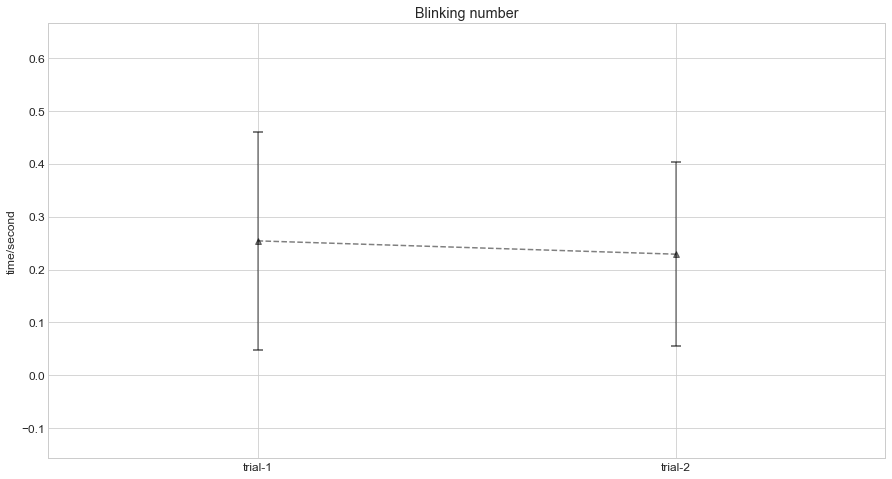

In [49]:
# ax = sns.distplot(y)
fig, ax = plt.subplots(figsize=(15,8))
plt.style.use('seaborn-whitegrid')

x_axis = ["trial-1", "trial-2"]
y_axis = [np.mean(x), np.mean(y)]
dy = [np.std(x), np.std(y)]
plt.margins(0.5)

ax.errorbar(x_axis, y_axis, yerr = dy, fmt='^--k', ecolor="black", capsize=5, capthick=2, alpha = 0.5)
plt.ylabel("time/second")
plt.title("Blinking number")
plt.show()


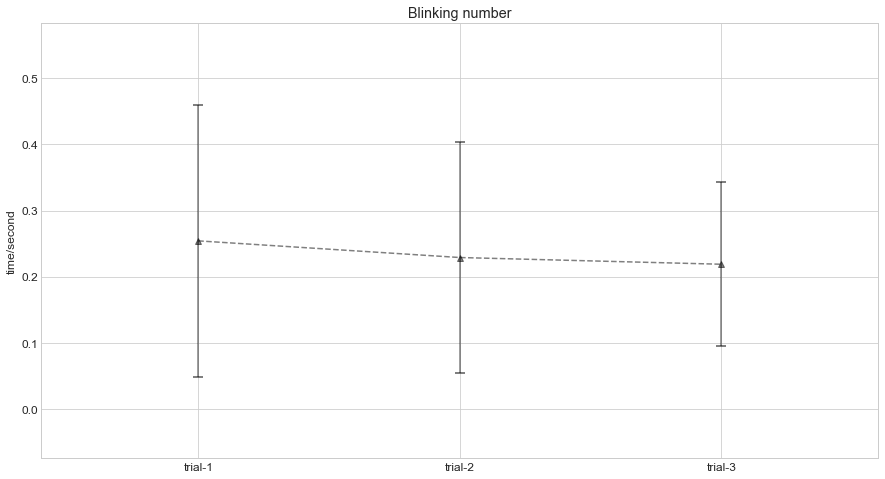

In [22]:
# ax = sns.distplot(y)
fig, ax = plt.subplots(figsize=(15,8))
plt.style.use('seaborn-whitegrid')

x_axis = ["trial-1", "trial-2", "trial-3"]
y_axis = [np.mean(x), np.mean(y), np.mean(z)]
dy = [np.std(x), np.std(y), np.std(z)]
plt.margins(0.3)

ax.errorbar(x_axis, y_axis, yerr = dy, fmt='^--k', ecolor="black", capsize=5, capthick=2, alpha = 0.5)
plt.ylabel("time/second")
plt.title("Blinking number")
plt.show()


## Number fixation

In [97]:
x = np.array([len(v) for v in trials[0]['Efix']])/np.array(trials[0]['total_time'])*1000
y = np.array([len(v) for v in trials[1]['Efix']])/np.array(trials[1]['total_time'])*1000
z = np.array([len(v) for v in trials[2]['Efix']])/np.array(trials[2]['total_time'])*1000

In [98]:
x = np.delete(x, 7)
y = np.delete(y, 7)

In [99]:
print("mean trial 1:", np.mean(x))
print("mean trial 2:", np.mean(y))
print("mean trial 3:", np.mean(z))

print("\nstd trial 1:", np.std(x))
print("std trial 2:", np.std(y))
print("std trial 3:", np.std(z))


mean trial 1: 2.4887887039780674
mean trial 2: 2.580351316779883
mean trial 3: 2.6251741108417073

std trial 1: 0.6862456065185083
std trial 2: 0.6325310188173199
std trial 3: 0.3803855557812346


In [77]:
scipy.stats.ttest_ind(y, z, equal_var = False)

Ttest_indResult(statistic=-0.33261782752104124, pvalue=0.740836209689104)

In [100]:
a = x - y
scipy.stats.ttest_1samp(a, 0)

Ttest_1sampResult(statistic=-1.168261706152446, pvalue=0.25190176380933604)

In [101]:
effect_size(y, x)

0.13874488672585283

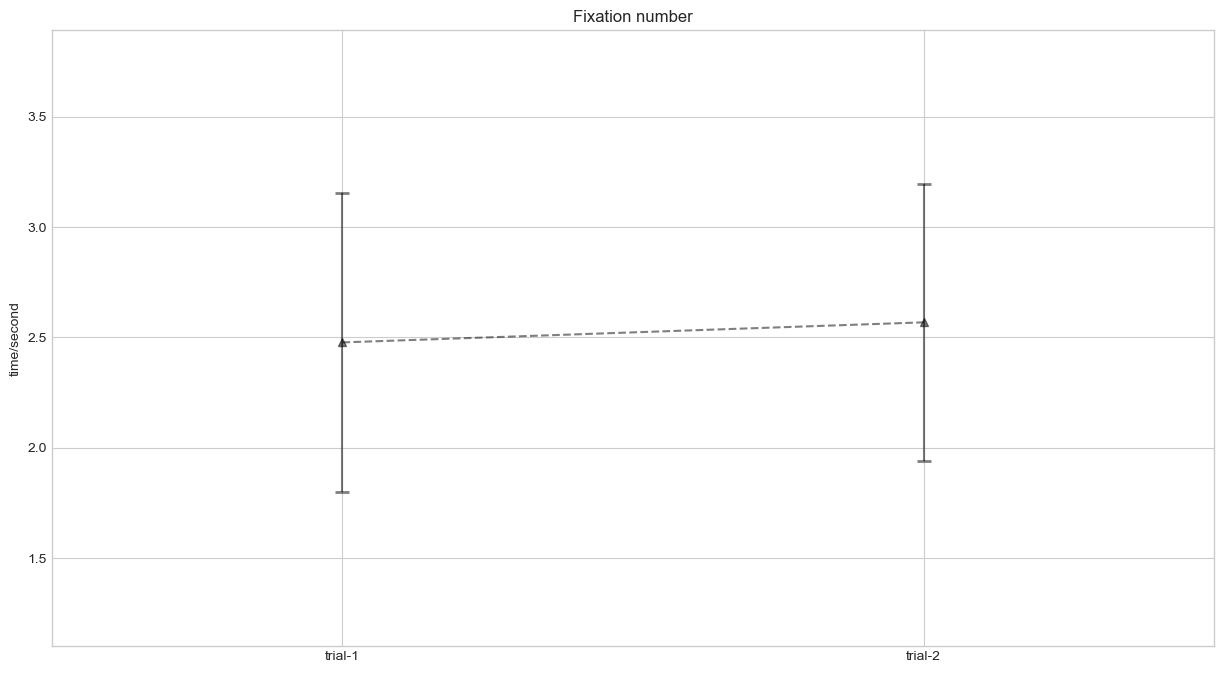

In [131]:
# ax = sns.distplot(y)
fig, ax = plt.subplots(figsize=(15,8))
plt.style.use('seaborn-whitegrid')

x_axis = ["trial-1", "trial-2"]
y_axis = [np.mean(x), np.mean(y)]
dy = [np.std(x), np.std(y)]
plt.margins(0.5)

ax.errorbar(x_axis, y_axis, yerr = dy, fmt='^--k', ecolor="black", capsize=5, capthick=2, alpha = 0.5)
plt.ylabel("time/second")
plt.title("Fixation number")
plt.show()


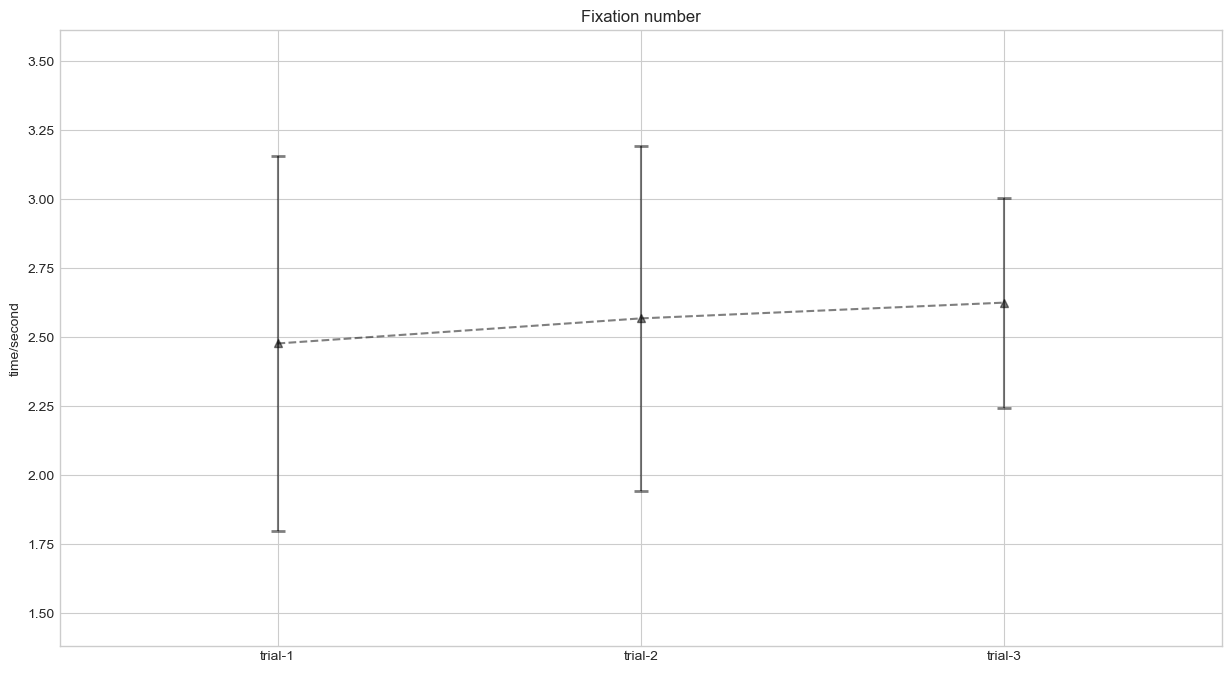

In [132]:
# ax = sns.distplot(y)
fig, ax = plt.subplots(figsize=(15,8))
plt.style.use('seaborn-whitegrid')

x_axis = ["trial-1", "trial-2", "trial-3"]
y_axis = [np.mean(x), np.mean(y), np.mean(z)]
dy = [np.std(x), np.std(y), np.std(z)]
plt.margins(0.3)

ax.errorbar(x_axis, y_axis, yerr = dy, fmt='^--k', ecolor="black", capsize=5, capthick=2, alpha = 0.5)
plt.ylabel("time/second")
plt.title("Fixation number")
plt.show()


## fixation duration

In [140]:
dur_fix = []
for g in groups:
    dur_fix1 = np.array([])
    mean_fix1 = []
    for i, p in enumerate(g[0]['Efix']):
        dur_fix1 = np.append(dur_fix1,np.array(p).T[2])
        mean_fix1.append(np.mean(np.array(p).T[2])/g[0]['total_time'][i])

    dur_fix2 = []
    mean_fix2 = []
    for i, p in enumerate(g[1]['Efix']):
        dur_fix2 = np.append(dur_fix2,np.array(p).T[2])
        mean_fix2.append(np.mean(np.array(p).T[2])/g[1]['total_time'][i])

    dur_fix3 = []
    mean_fix3 = []
    for i, p in enumerate(g[2]['Efix']):
        dur_fix3 = np.append(dur_fix3,np.array(p).T[2])
        mean_fix3.append(np.mean(np.array(p).T[2])/g[2]['total_time'][i])
        
    dur_fix.append([dur_fix1,dur_fix2,dur_fix3])
    

In [141]:
print("GROUP 1")
print("mean trial 1:", np.mean(dur_fix[0][0]))
print("mean trial 2:", np.mean(dur_fix[0][1]))
print("mean trial 3:", np.mean(dur_fix[0][2]))

print("\nstd trial 1:", np.std(dur_fix[0][0]))
print(  "std trial 2:", np.std(dur_fix[0][1]))
print(  "std trial 3:", np.std(dur_fix[0][2]))

print("--------------------------")
print("GROUP 2")
print("mean trial 1:", np.mean(dur_fix[1][0]))
print("mean trial 2:", np.mean(dur_fix[1][1]))
print("mean trial 3:", np.mean(dur_fix[1][2]))

print("\nstd trial 1:", np.std(dur_fix[1][0]))
print(  "std trial 2:", np.std(dur_fix[1][1]))
print(  "std trial 3:", np.std(dur_fix[1][2]))

GROUP 1
mean trial 1: 204.40369556977026
mean trial 2: 204.2687406858598
mean trial 3: 205.45100911161882

std trial 1: 199.9427968851456
std trial 2: 191.52683624893587
std trial 3: 182.2572849996305
--------------------------
GROUP 2
mean trial 1: 203.9062511033328
mean trial 2: 216.55536761778345
mean trial 3: 198.14541759112814

std trial 1: 190.51646988803185
std trial 2: 202.51649652261278
std trial 3: 175.01682092024961


In [145]:
scipy.stats.ttest_ind(dur_fix[0][2], dur_fix[1][2], equal_var = False)

Ttest_indResult(statistic=0.9265604330095188, pvalue=0.35427651172364394)

In [146]:
effect_size(dur_fix[0][1], dur_fix[1][1])

0.06212790176260563

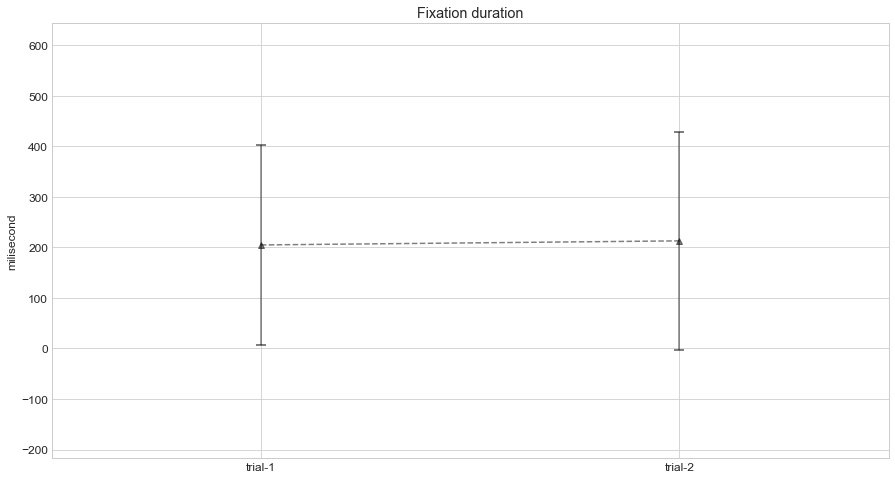

In [51]:
# ax = sns.distplot(y)
fig, ax = plt.subplots(figsize=(15,8))
plt.style.use('seaborn-whitegrid')

x_axis = ["trial-1", "trial-2"]
y_axis = [np.mean(dur_fix1), np.mean(dur_fix2)]
dy = [np.std(dur_fix1), np.std(dur_fix2)]
plt.margins(0.5)

ax.errorbar(x_axis, y_axis, yerr = dy, fmt='^--k', ecolor="black", capsize=5, capthick=2, alpha = 0.5)
plt.ylabel("milisecond")
plt.title("Fixation duration")
plt.show()


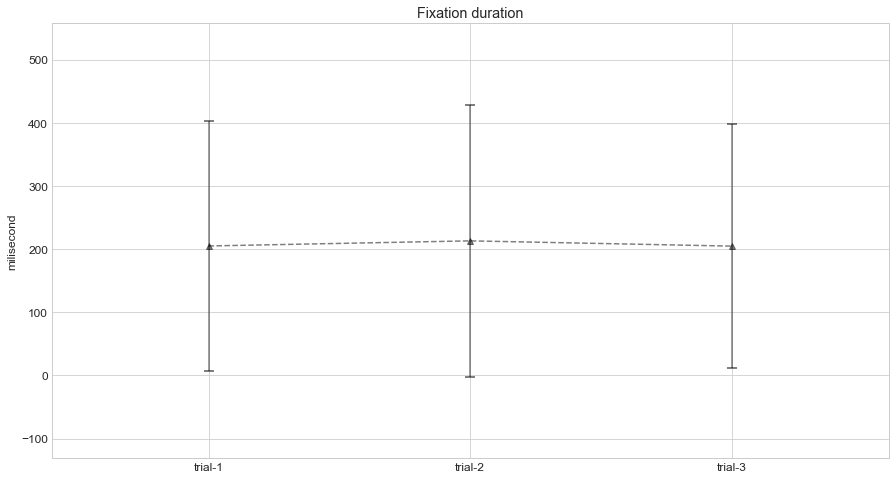

In [27]:
# ax = sns.distplot(y)
fig, ax = plt.subplots(figsize=(15,8))
plt.style.use('seaborn-whitegrid')

x_axis = ["trial-1", "trial-2", "trial-3"]
y_axis = [np.mean(dur_fix1), np.mean(dur_fix2), np.mean(dur_fix3)]
dy = [np.std(dur_fix1), np.std(dur_fix2), np.std(dur_fix3)]
plt.margins(0.3)

ax.errorbar(x_axis, y_axis, yerr = dy, fmt='^--k', ecolor="black", capsize=5, capthick=2, alpha = 0.5)
plt.ylabel("milisecond")
plt.title("Fixation duration")
plt.show()


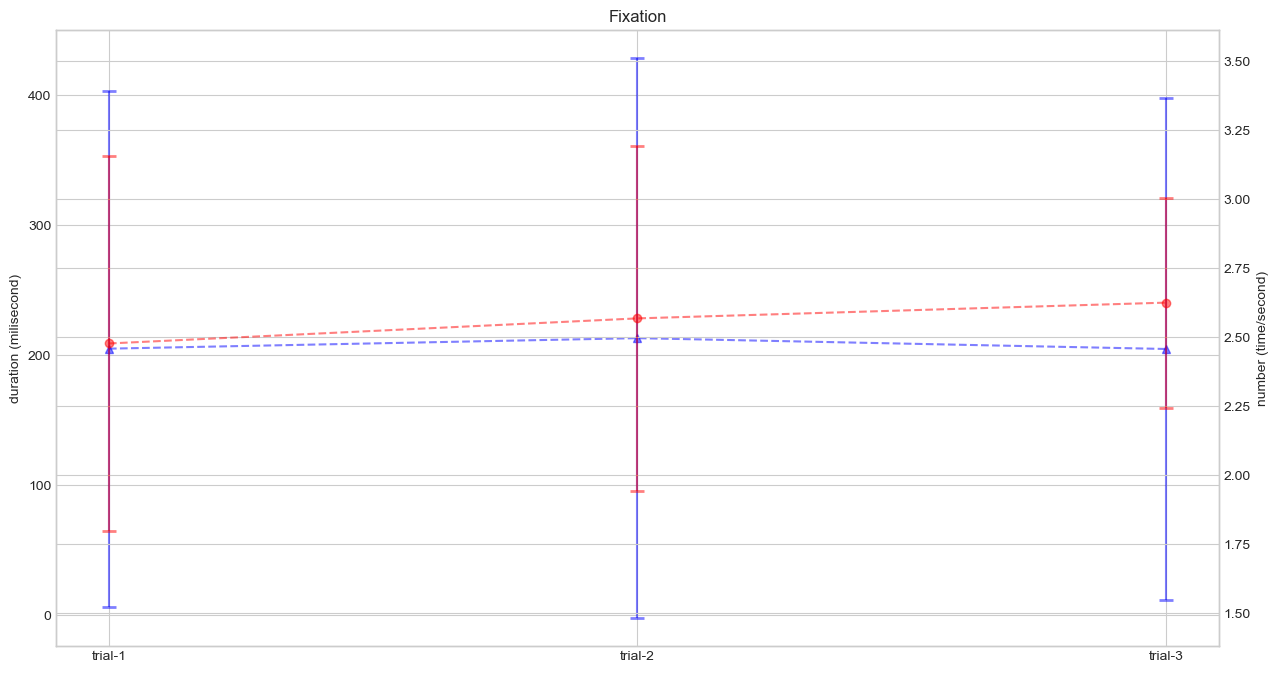

In [138]:
fig, ax1 = plt.subplots(figsize=(15,8))
plt.style.use('seaborn-whitegrid')

x_axis = ["trial-1", "trial-2", "trial-3"]
y_axis = [np.mean(dur_fix1), np.mean(dur_fix2), np.mean(dur_fix3)]
dy = [np.std(dur_fix1), np.std(dur_fix2), np.std(dur_fix3)]
ax1.errorbar(x_axis, y_axis, yerr = dy, fmt='^--b', ecolor="blue", capsize=5, capthick=2, alpha = 0.5)

ax2 = ax1.twinx()
y_axis = [np.mean(x), np.mean(y), np.mean(z)]
dy = [np.std(x), np.std(y), np.std(z)]
ax2.errorbar(x_axis, y_axis, yerr = dy, fmt='o--r', ecolor="red", capsize=5, capthick=2, alpha = 0.5)

plt.margins(0.3)
ax1.set_ylabel("duration (milisecond)")
ax2.set_ylabel("number (time/second)")

plt.title("Fixation")
plt.show()


## num saccade

In [104]:
x = np.array([len(v) for v in trials[0]['Esac']])/np.array(trials[0]['total_time'])*1000
y = np.array([len(v) for v in trials[1]['Esac']])/np.array(trials[1]['total_time'])*1000
z = np.array([len(v) for v in trials[2]['Esac']])/np.array(trials[2]['total_time'])*1000

In [105]:
x = np.delete(x, 7)
y = np.delete(y, 7)

In [106]:
print("mean trial 1:", np.mean(x))
print("mean trial 2:", np.mean(y))
print("mean trial 3:", np.mean(z))

print("\nstd trial 1:", np.std(x))
print("std trial 2:", np.std(y))
print("std trial 3:", np.std(z))

mean trial 1: 3.2438551945693876
mean trial 2: 3.4593020572831743
mean trial 3: 3.4381656669093594

std trial 1: 1.101895847639745
std trial 2: 1.132773352486285
std trial 3: 0.6995884354200584


In [83]:
scipy.stats.ttest_ind(y, z, equal_var = False)

Ttest_indResult(statistic=0.08695331508060508, pvalue=0.9310560705065268)

In [107]:
a = x - y
scipy.stats.ttest_1samp(a, 0)

Ttest_1sampResult(statistic=-2.5237858895319736, pvalue=0.017139023717519374)

In [85]:
effect_size(y, z)

0.022451249413647317

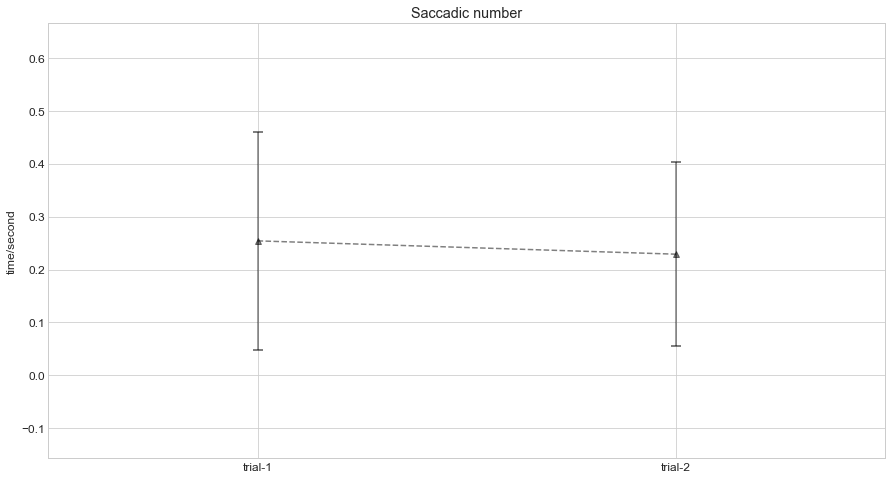

In [52]:
fig, ax = plt.subplots(figsize=(15,8))
plt.style.use('seaborn-whitegrid')

x_axis = ["trial-1", "trial-2"]
y_axis = [np.mean(x), np.mean(y)]
dy = [np.std(x), np.std(y)]
plt.margins(0.5)

ax.errorbar(x_axis, y_axis, yerr = dy, fmt='^--k', ecolor="black", capsize=5, capthick=2, alpha = 0.5)
plt.ylabel("time/second")
plt.title("Saccadic number")
plt.show()

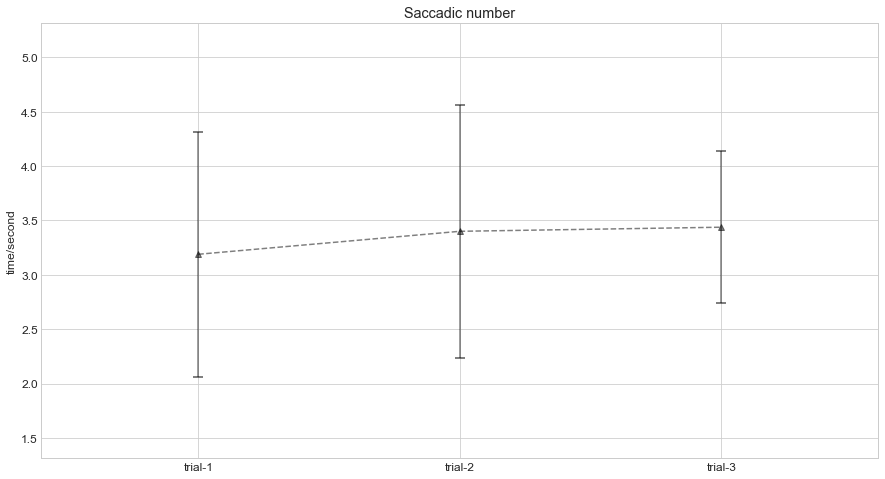

In [31]:
fig, ax = plt.subplots(figsize=(15,8))
plt.style.use('seaborn-whitegrid')

x_axis = ["trial-1", "trial-2", "trial-3"]
y_axis = [np.mean(x), np.mean(y), np.mean(z)]
dy = [np.std(x), np.std(y), np.std(z)]
plt.margins(0.3)

ax.errorbar(x_axis, y_axis, yerr = dy, fmt='^--k', ecolor="black", capsize=5, capthick=2, alpha = 0.5)
plt.ylabel("time/second")
plt.title("Saccadic number")
plt.show()

## GTE

In [152]:
len(groups[0][2]["Ht"])

10

In [155]:
gte = []
for g in groups:

    gte1 = g[0]['Ht']
    gte2 = g[1]['Ht']
    gte3 = g[2]['Ht']
    gte.append([gte1,gte2,gte3])

In [156]:
print("GROUP 1")
print("mean trial 1:", np.mean(gte[0][0]))
print("mean trial 2:", np.mean(gte[0][1]))
print("mean trial 3:", np.mean(gte[0][2]))

print("\nstd trial 1:", np.std(gte[0][0]))
print("std trial 2:", np.std(gte[0][1]))
print("std trial 2:", np.std(gte[0][2]))

print("-----------------------------")
print("GROUP 2")
print("mean trial 1:", np.mean(gte[1][0]))
print("mean trial 2:", np.mean(gte[1][1]))
print("mean trial 3:", np.mean(gte[1][2]))

print("\nstd trial 1:", np.std(gte[1][0]))
print("std trial 2:", np.std(gte[1][1]))
print("std trial 2:", np.std(gte[1][2]))

GROUP 1
mean trial 1: 1.0807025587639763
mean trial 2: 1.0610754681499375
mean trial 3: 1.3984240110388713

std trial 1: 0.16860950410030703
std trial 2: 0.23836251794453747
std trial 2: 0.20814554351550482
-----------------------------
GROUP 2
mean trial 1: 1.1909855713734065
mean trial 2: 1.132499987256989
mean trial 3: 1.34530484547176

std trial 1: 0.2614571330355321
std trial 2: 0.2705067583257731
std trial 2: 0.4641994181425891


In [159]:
scipy.stats.ttest_ind(gte[0][2], gte[1][2], equal_var = False)

Ttest_indResult(statistic=0.3632058680936936, pvalue=0.720399526349748)

In [161]:
a = gte2 - gte1
scipy.stats.ttest_1samp(a, 0)

TypeError: unsupported operand type(s) for -: 'list' and 'list'

# SGE

In [184]:
x = -1 * np.array([ trials[0]['Hs'], trials[1]['Hs']]).T

In [185]:
x1 = []
for v in x:
    if True not in np.isnan(v):
        x1.append(v)
        
x1 = np.stack(x1, axis=0)
sge1 = x1.T[0]
sge2 = x1.T[1]

In [186]:
print("mean trial 1:", np.mean(sge1))
print("mean trial 2:", np.mean(sge2))
print("std trial 1:", np.std(sge1))
print("std trial 2:", np.std(sge2))

mean trial 1: 1.597449198198301
mean trial 2: 1.5422892290122738
std trial 1: 0.3114136195146367
std trial 2: 0.294279903871427


In [187]:
scipy.stats.ttest_ind(sge1, sge2, equal_var = False)

Ttest_indResult(statistic=0.7167921469068368, pvalue=0.4762025593977536)

In [188]:
a = sge2 - sge1
scipy.stats.ttest_1samp(a, 0)

Ttest_1sampResult(statistic=-0.7852301822346631, pvalue=0.43827900322044366)

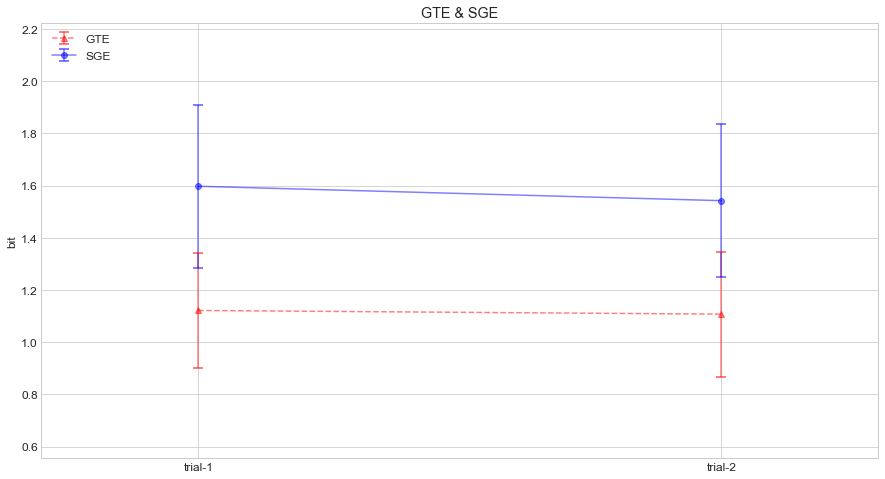

In [189]:
fig, ax = plt.subplots(figsize=(15,8))
plt.style.use('seaborn-whitegrid')

x_axis = ["trial-1", "trial-2"]
y_axis = [np.mean(gte1), np.mean(gte2)]
dy = [np.std(gte1), np.std(gte2)]

ax.errorbar(x_axis, y_axis, yerr = dy, fmt='^--r', ecolor="red", capsize=5, capthick=2, alpha = 0.5, label = "GTE")

y_axis = [np.mean(sge1), np.mean(sge2)]
dy = [np.std(sge1), np.std(sge2)]

ax.errorbar(x_axis, y_axis, yerr = dy, fmt='o-b', ecolor="blue", capsize=5, capthick=2, alpha = 0.5, label = "SGE")

plt.legend(loc="upper left")
plt.margins(0.3)
plt.ylabel("bit")
plt.title("GTE & SGE")
plt.show()

## GTE 1,2 vs 3

In [39]:
x1 = trials[0]['Ht'][:]
x2 = trials[1]['Ht'][:]

In [40]:
len(x1)

32

In [41]:
x1.pop(7)
x2.pop(7)

0.9948072178415929

In [42]:
x = np.array([x1,x2,trials[2]['Ht']]).T

In [43]:
x1 = []
for v in x:
    if True not in np.isnan(v):
        x1.append(v)
        
x1 = np.stack(x1, axis=0)
gte1 = x1.T[0]
gte2 = x1.T[1]
gte3 = x1.T[2]

In [44]:
print("mean trial 1:", np.mean(gte1))
print("mean trial 2:", np.mean(gte2))
print("mean trial 3:", np.mean(gte3))

print("\nstd trial 1:", np.std(gte1))
print("std trial 2:", np.std(gte2))
print("std trial 3:", np.std(gte3))

mean trial 1: 1.1222304460202481
mean trial 2: 1.111313095268339
mean trial 3: 1.369035003221762

std trial 1: 0.22460470437912708
std trial 2: 0.24283733088455509
std trial 3: 0.3620576734228392


In [46]:
scipy.stats.ttest_ind(gte2, gte1, equal_var = False)

Ttest_indResult(statistic=-3.2379600300906803, pvalue=0.002089999132747986)

In [47]:
a = gte2 - gte3
scipy.stats.ttest_1samp(a, 0)

Ttest_1sampResult(statistic=-3.2546020491394154, pvalue=0.0028122855105399296)

In [110]:
effect_size(gte2, gte1)

0.04667554294820108

## SGE 1,2 vs 3

In [48]:
x1 = trials[0]['Hs'][:]
x2 = trials[1]['Hs'][:]

x1.pop(7)
x2.pop(7)

x = -1 * np.array([ x1, x2, trials[2]['Hs']]).T

In [49]:
x1 = []
for v in x:
    if True not in np.isnan(v):
        x1.append(v)

x1 = np.stack(x1, axis=0)
sge1 = x1.T[0]
sge2 = x1.T[1]
sge3 = x1.T[2]

In [50]:
print("mean trial 1:", np.mean(sge1))
print("mean trial 2:", np.mean(sge2))
print("mean trial 3:", np.mean(sge3))

print("\nstd trial 1:", np.std(sge1))
print("std trial 2:", np.std(sge2))
print("std trial 3:", np.std(sge3))

mean trial 1: 1.5945270146756358
mean trial 2: 1.5448613032984198
mean trial 3: 1.9018030078024604

std trial 1: 0.3178126235512101
std trial 2: 0.3020071931766007
std trial 3: 0.49936639717006054


In [52]:
scipy.stats.ttest_ind(sge2, sge3, equal_var = False)
# scipy.stats.ttest_ind(sge2, sge3, equal_var = False)

Ttest_indResult(statistic=-3.293743823076482, pvalue=0.0018677783491407253)

In [27]:
a = sge3 - sge1
scipy.stats.ttest_1samp(a, 0)

Ttest_1sampResult(statistic=2.8679085632660017, pvalue=0.007624459995472508)

In [109]:
effect_size(sge1, sge2)

0.1602064674036634

findfont: Font family ['Ubuntu'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Ubuntu'] not found. Falling back to DejaVu Sans.


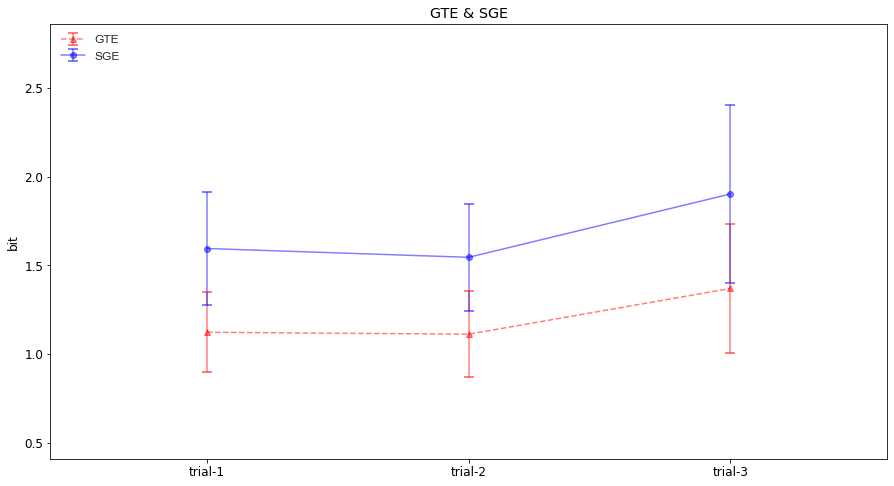

In [26]:
fig, ax = plt.subplots(figsize=(15,8))
plt.style.use('seaborn-whitegrid')

x_axis = ["trial-1", "trial-2", "trial-3"]
y_axis = [np.mean(gte1), np.mean(gte2), np.mean(gte3)]
dy = [np.std(gte1), np.std(gte2), np.std(gte3)]

ax.errorbar(x_axis, y_axis, yerr = dy, fmt='^--r', ecolor="red", capsize=5, capthick=2, alpha = 0.5, label = "GTE")

y_axis = [np.mean(sge1), np.mean(sge2), np.mean(sge3)]
dy = [np.std(sge1), np.std(sge2), np.std(sge3)]

ax.errorbar(x_axis, y_axis, yerr = dy, fmt='o-b', ecolor="blue", capsize=5, capthick=2, alpha = 0.5, label = "SGE")

plt.legend(loc="upper left")
plt.margins(0.3)
plt.ylabel("bit")
plt.title("GTE & SGE")
plt.show()